In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_4378.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_747.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_561.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_345.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3019.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_2566.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3156.jpg
/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_3889.jpg
/kaggle/input/human-action-recognition-har-dataset

# 1| what is HAR
* Human activity recognition, or HAR for short, is a broad field of study concerned with identifying the specific movement or action of a person based on sensor data.
* Movements are often typical activities performed indoors, such as walking, talking, standing, and sitting


# Why it is important ?
* Human activity recognition plays a significant role in human-to-human interaction and interpersonal relations.
* Because it provides information about the identity of a person, their personality, and psychological state, it is difficult to extract.
* The human ability to recognize another person’s activities is one of the main subjects of study of the scientific areas of computer vision and machine learning. As a result of this research, many applications, including video surveillance systems, human-computer interaction, and robotics for human behavior characterization, require a multiple activity recognition system.

# 2| Importing libraries

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd

import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

from PIL import Image

from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# 3| Getting the path and Loading the data

In [3]:
train_data = pd.read_csv("../input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv")
test_data = pd.read_csv("../input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv")

In [4]:
train_fol = glob.glob("../input/human-action-recognition-har-dataset/Human Action Recognition/train/*") 
test_fol = glob.glob("../input/human-action-recognition-har-dataset/Human Action Recognition/test/*")

In [5]:
train_data

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop
...,...,...
12595,Image_12596.jpg,sitting
12596,Image_12597.jpg,clapping
12597,Image_12598.jpg,sitting
12598,Image_12599.jpg,dancing


In [6]:
train_data.label.value_counts()

label
sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: count, dtype: int64

In [7]:
len(train_data.label.unique())

15

In [8]:
import plotly.express as px
HAR = train_data.label.value_counts()
fig = px.pie(train_data, values=HAR.values, names=HAR.index, title='Distribution of Human Activity')
fig.show()

In [9]:
filename = train_data['filename']

situation = train_data['label']

In [10]:
filename

0            Image_1.jpg
1            Image_2.jpg
2            Image_3.jpg
3            Image_4.jpg
4            Image_5.jpg
              ...       
12595    Image_12596.jpg
12596    Image_12597.jpg
12597    Image_12598.jpg
12598    Image_12599.jpg
12599    Image_12600.jpg
Name: filename, Length: 12600, dtype: object

# 4| Making function that take random path and display the image

In [11]:
def displaying_random_images():
    num = random.randint(1,10000)
    imgg = "Image_{}.jpg".format(num)
    train = "../input/human-action-recognition-har-dataset/Human Action Recognition/train/"
    if os.path.exists(train+imgg):
        testImage = img.imread(train+imgg)
        plt.imshow(testImage)
        plt.title("{}".format(train_data.loc[train_data['filename'] == "{}".format(imgg), 'label'].item()))

    else:
        #print(train+img)
        print("File Path not found \nSkipping the file!!")

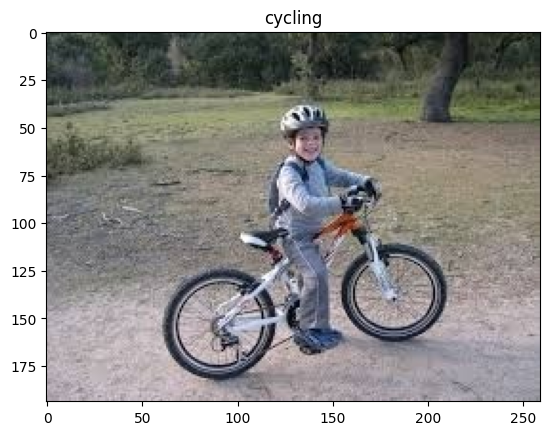

In [12]:
displaying_random_images()

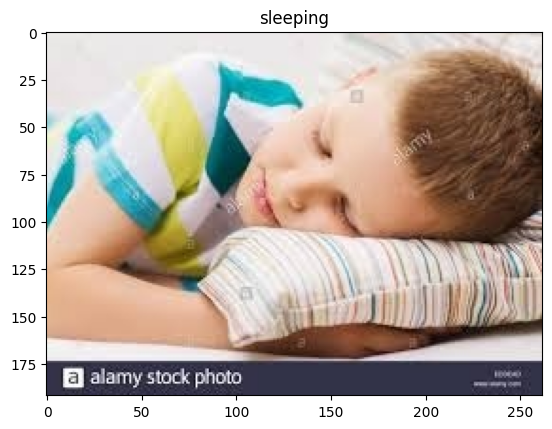

In [13]:
displaying_random_images()

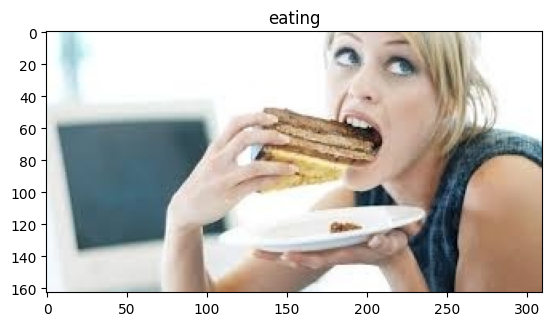

In [14]:
displaying_random_images()

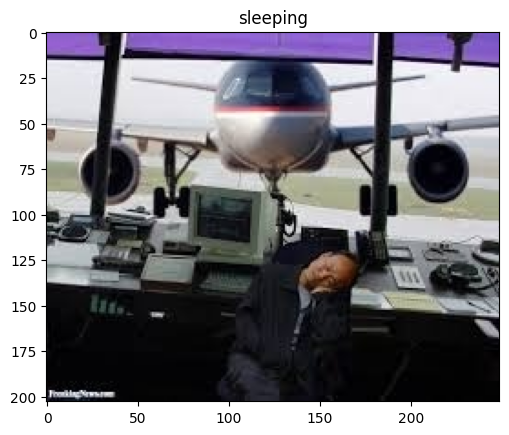

In [15]:
displaying_random_images()

# 5| Data preprocessing

In [16]:
img_data = []
img_label = []
length = len(train_fol)
for i in (range(len(train_fol)-1)):
    t = '../input/human-action-recognition-har-dataset/Human Action Recognition/train/' + filename[i]    
    temp_img = Image.open(t)
    img_data.append(np.asarray(temp_img.resize((160,160))))
    img_label.append(situation[i])

In [17]:
img_shape= (160,160,3)

In [18]:
iii = img_data
iii = np.asarray(iii)
type(iii)

numpy.ndarray

In [19]:
y_train = to_categorical(np.asarray(train_data["label"].factorize()[0]))
print(y_train[0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
print(len(y_train[0]))

15


# 6| Make an CNN model

In [21]:
efficientnet_model = Sequential()

model = tf.keras.applications.EfficientNetB7(include_top=False,
                                            input_shape=(160,160,3),
                                            pooling ="avg",classes=15,
                                             weights="imagenet")

for layer in model.layers:
    layer.trainable=False
    

efficientnet_model.add(model)
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(512,activation="relu"))
efficientnet_model.add(Dense(15,activation="softmax"))

258076736/258076736 [==============================] - 9s 0us/step


In [22]:
efficientnet_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [23]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 65416614 (249.54 MB)
Trainable params: 1318927 (5.03 MB)
Non-trainable params: 64097687 (244.51 MB)
_________________________________________________________________


In [24]:
history = efficientnet_model.fit(iii,y_train,epochs=40)

Epoch 1/40


2026-01-12 02:06:19.087601: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


394/394 [==============================] - 71s 125ms/step - loss: 1.2623 - accuracy: 0.5997
Epoch 2/40
394/394 [==============================] - 49s 125ms/step - loss: 0.8704 - accuracy: 0.7173
Epoch 3/40
394/394 [==============================] - 49s 125ms/step - loss: 0.6552 - accuracy: 0.7850
Epoch 4/40
394/394 [==============================] - 49s 125ms/step - loss: 0.4795 - accuracy: 0.8466
Epoch 5/40
394/394 [==============================] - 49s 125ms/step - loss: 0.3339 - accuracy: 0.8952
Epoch 6/40
394/394 [==============================] - 49s 125ms/step - loss: 0.2326 - accuracy: 0.9281
Epoch 7/40
394/394 [==============================] - 49s 125ms/step - loss: 0.1703 - accuracy: 0.9504
Epoch 8/40
394/394 [==============================] - 49s 125ms/step - loss: 0.1413 - accuracy: 0.9576
Epoch 9/40
394/394 [==============================] - 49s 125ms/step - loss: 0.1202 - accuracy: 0.9639
Epoch 10/40
394/394 [==============================] - 49s 125ms/step - loss: 0.1084

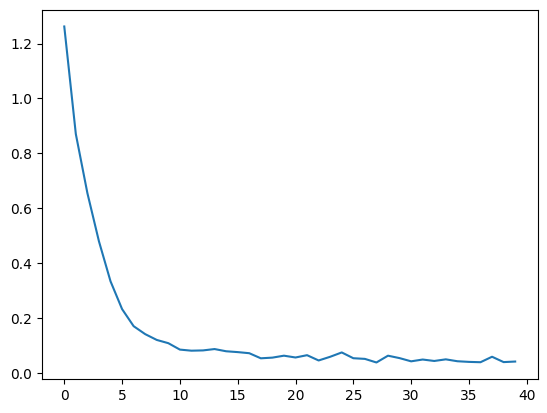

In [25]:
losses = history.history["loss"]
plt.plot(losses)

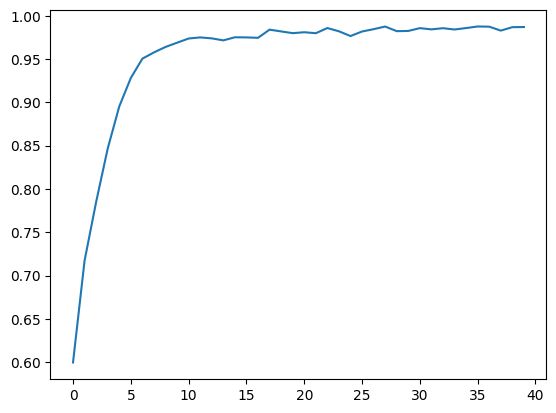

In [26]:
acc = history.history['accuracy']
plt.plot(acc)

# 7| Model predictions

In [27]:
def read_img(fn):
    img = Image.open(fn)
    return np.asarray(img.resize((160,160)))

In [28]:
def test_predict(test_image):
    result = efficientnet_model.predict(np.asarray([read_img(test_image)]))

    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", prediction)

    image = img.imread(test_image)
    plt.imshow(image)
    plt.title(prediction)

1/1 [==============================] - 5s 5s/step
probability: 98.18244576454163%
Predicted class :  1


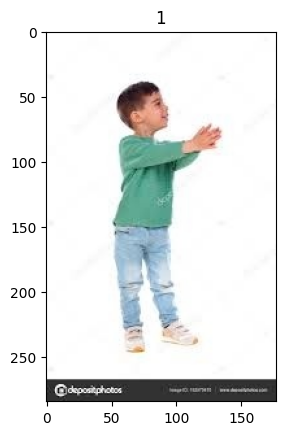

In [29]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1001.jpg")

1/1 [==============================] - 0s 40ms/step
probability: 98.79114627838135%
Predicted class :  4


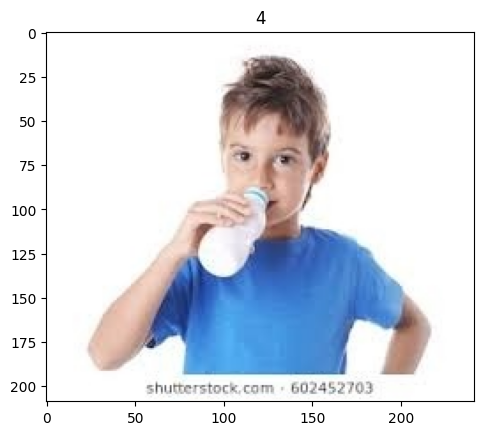

In [30]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_101.jpg")

1/1 [==============================] - 0s 42ms/step
probability: 33.26006829738617%
Predicted class :  11


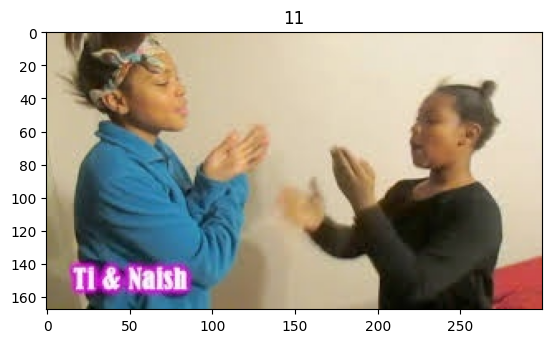

In [31]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1056.jpg")

1/1 [==============================] - 0s 44ms/step
probability: 99.99842643737793%
Predicted class :  14


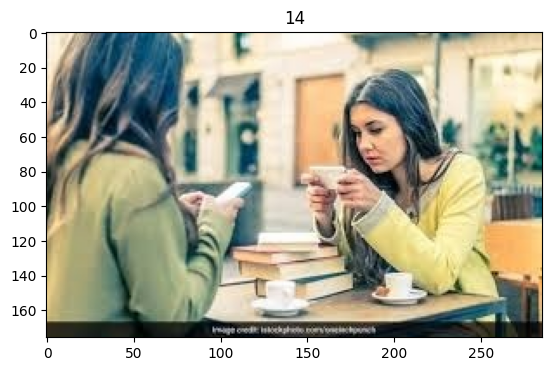

In [32]:
test_predict("/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test/Image_1024.jpg")

In [33]:
train_data["label"].factorize()

(array([ 0,  1,  2, ...,  0,  6, 12]),
 Index(['sitting', 'using_laptop', 'hugging', 'sleeping', 'drinking',
        'clapping', 'dancing', 'cycling', 'calling', 'laughing', 'eating',
        'fighting', 'listening_to_music', 'running', 'texting'],
       dtype='object'))

In [34]:
label_map = dict(enumerate(train_data["label"].factorize()[1]))

In [35]:
pred_label = label_map[14]
print(pred_label)

texting


In [36]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]